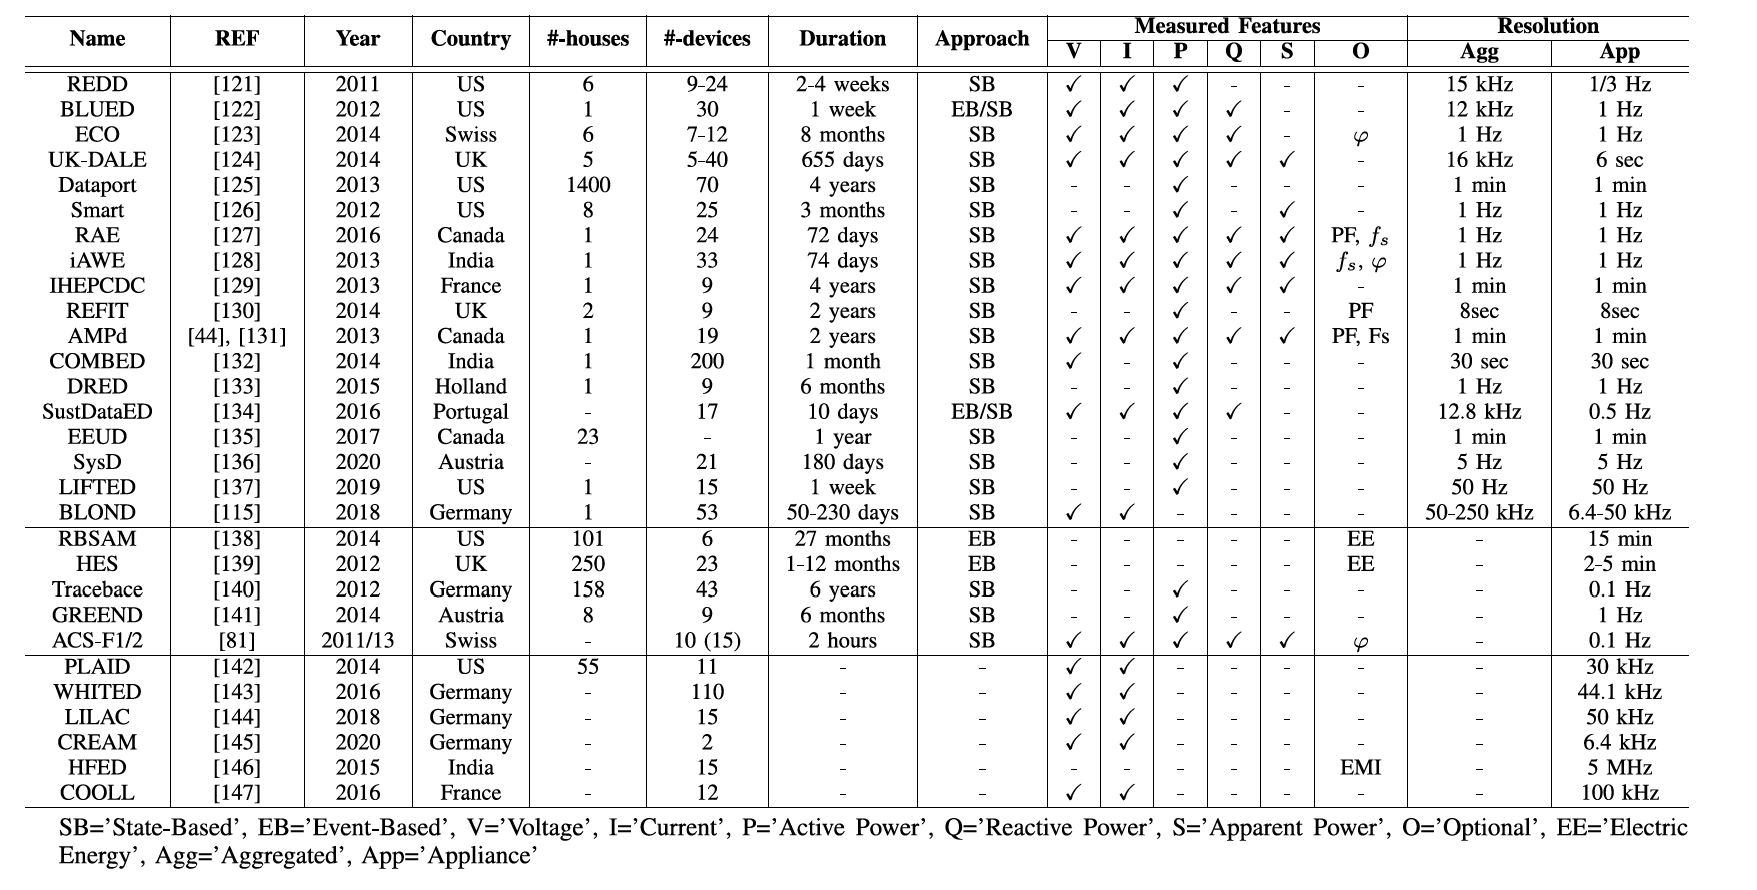

In [4]:
# Load dataset
from nilmtk import DataSet
ukdale = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Show all buildings
print("Buildings:", ukdale.buildings.keys())


Buildings: odict_keys([1, 2, 3, 4, 5])


hierarchical database in UKDALE
```text
/building1/
    electricity/
        mains/1
        appliance/1
        appliance/2
    metadata.yaml
/building2/...
```


In [5]:
# Pick one building
building1 = dataset.buildings[1]
elec1 = building1.elec

In [6]:
print("Available appliances (sorted by name):")

# Extract (type, instance) from each appliance
appliance_list = [(app.metadata['type'], app.metadata['instance']) for app in elec1.appliances]

# Sort by appliance name, then by instance number
appliance_list = sorted(appliance_list, key=lambda x: (x[0].lower(), x[1]))

# Print list
for appl_type, instance in appliance_list:
    print(f"- {appl_type} (instance {instance})")

# Print total count
print(f"\nTotal number of appliances: {len(appliance_list)}")


Available appliances (sorted by name):
- active subwoofer (instance 1)
- audio amplifier (instance 1)
- audio system (instance 1)
- audio system (instance 2)
- baby monitor (instance 1)
- baby monitor (instance 2)
- boiler (instance 1)
- breadmaker (instance 1)
- broadband router (instance 1)
- charger (instance 1)
- clothes iron (instance 1)
- coffee maker (instance 1)
- computer (instance 1)
- computer monitor (instance 1)
- desktop computer (instance 1)
- dish washer (instance 1)
- drill (instance 1)
- ethernet switch (instance 1)
- external hard disk (instance 1)
- fan (instance 1)
- fan (instance 2)
- food processor (instance 1)
- food processor (instance 2)
- fridge freezer (instance 1)
- hair dryer (instance 1)
- hair straighteners (instance 1)
- HTPC (instance 1)
- immersion heater (instance 1)
- kettle (instance 1)
- kitchen aid (instance 1)
- laptop computer (instance 1)
- laptop computer (instance 2)
- laptop computer (instance 3)
- light (instance 1)
- light (instance 2)
- 

In [7]:
# Show aggregate mains
mains = elec1.mains()
print(mains)

ElecMeter(instance=54, building=1, dataset='UK-DALE', site_meter, appliances=[Appliance(type='immersion heater', instance=1), Appliance(type='water pump', instance=1), Appliance(type='security alarm', instance=1), Appliance(type='fan', instance=2), Appliance(type='drill', instance=1), Appliance(type='laptop computer', instance=2)])


In [8]:
# Show fridge (if available)
fridge = elec1['fridge']
print(fridge)

ElecMeter(instance=12, building=1, dataset='UK-DALE', appliances=[Appliance(type='fridge freezer', instance=1)])


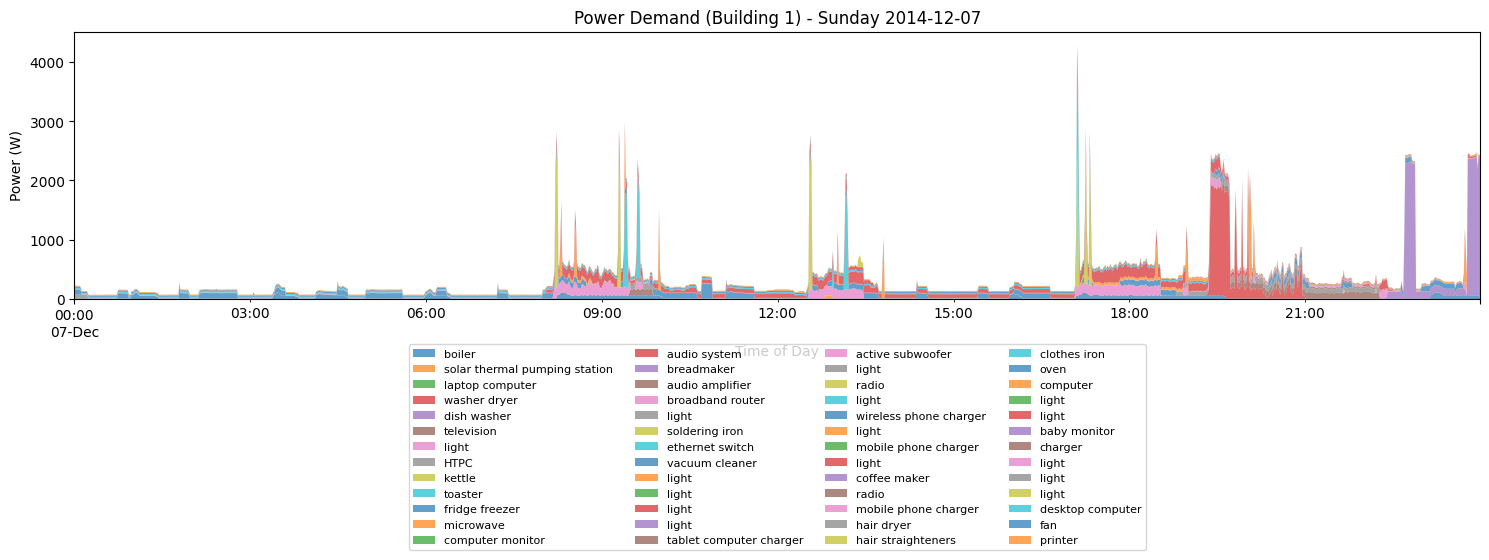

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-07"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Prepare dataframe for each appliance
appliance_dfs = []
labels = []
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data (full, then slice by time)
    df = next(appliance.load(sample_period=60))
    df = df[start:end]   # time slice using Pandas
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    appliance_dfs.append(y)
    labels.append(label)

# Combine into single dataframe
df_all = pd.concat(appliance_dfs, axis=1)
df_all.columns = labels
df_all = df_all.fillna(0)

# Plot stacked area chart
plt.figure(figsize=(15,6))
df_all.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

plt.title("Power Demand (Building 1) - Sunday 2014-12-07")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")

# Legend below plot
plt.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.15),  # position below
    ncol=4,                       # number of columns for compact layout
    fontsize=8
)

plt.tight_layout()
plt.show()


C:\Users\Raymond Tie\AppData\Local\Temp\ipykernel_24464\3606855937.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_major["Others"] = df_others


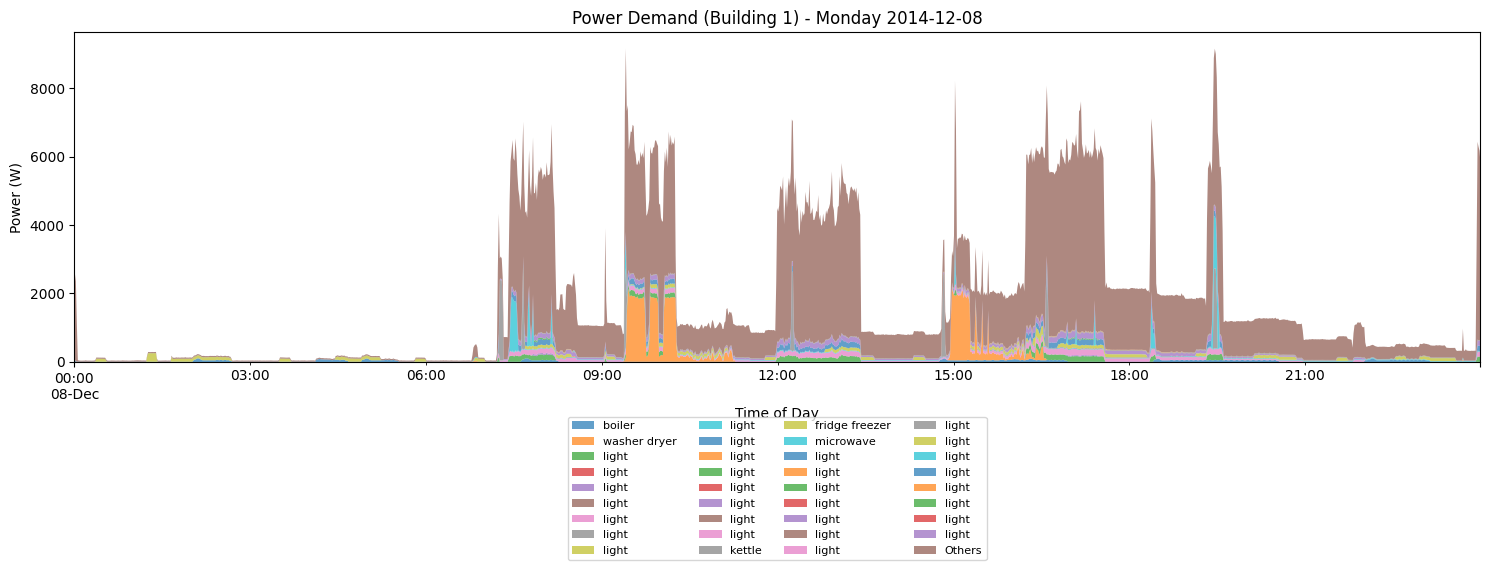

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-08"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Prepare dataframe for each appliance
appliance_dfs = []
labels = []
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data
    df = next(appliance.load(sample_period=60))
    df = df[start:end]   # slice by time
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    appliance_dfs.append(y)
    labels.append(label)

# Combine into single dataframe
df_all = pd.concat(appliance_dfs, axis=1)
df_all.columns = labels
df_all = df_all.fillna(0)

# --- Group small contributors into "Others" ---
energy_sum = df_all.sum()
threshold = 0.05 * energy_sum.sum()   # 5% of total energy
major_appliances = energy_sum[energy_sum >= threshold].index
minor_appliances = energy_sum[energy_sum < threshold].index

df_major = df_all[major_appliances]
df_others = df_all[minor_appliances].sum(axis=1)
df_major["Others"] = df_others

# Plot stacked area chart
plt.figure(figsize=(15,6))
df_major.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

plt.title("Power Demand (Building 1) - Monday 2014-12-08")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")

# Legend moved below plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),  # push below the x-axis
    ncol=4,                       # arrange in columns
    fontsize=8
)

plt.tight_layout()
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
C:\Users\Raymond Tie\AppData\Local\Temp\ipykernel_24464\1735364344.py:58: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(mains_active.index, mains_active, color="black", label="Mains (active power)", linewidth=1.5)


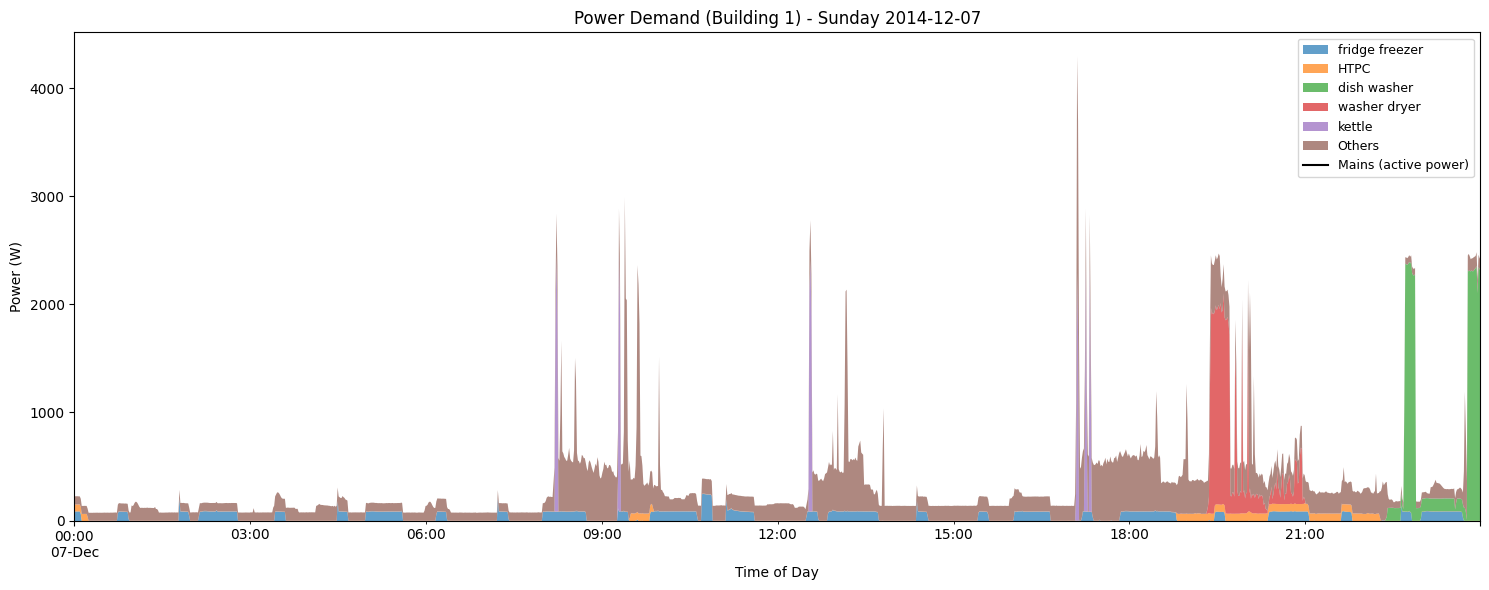

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
building = dataset.buildings[1]
elec = building.elec

# Select the day
day = "2014-12-07"
start = pd.Timestamp(day + " 00:00:00", tz="UTC")
end = pd.Timestamp(day + " 23:59:59", tz="UTC")

# Target appliance categories to group
target_appliances = ["fridge freezer", "HTPC", "dish washer", "washer dryer", "kettle"]

# Collect appliance data
appliance_dfs = {}
for appliance in elec.submeters().meters:
    label = appliance.appliances[0].type['type'] if appliance.appliances else "unknown"
    
    # Load data
    df = next(appliance.load(sample_period=60))
    df = df[start:end]
    
    if ('power', 'active') in df.columns:
        y = df[('power', 'active')]
    else:
        y = df.iloc[:, 0]
        
    # Group by appliance type (ignore instance)
    if label in appliance_dfs:
        appliance_dfs[label] = appliance_dfs[label].add(y, fill_value=0)
    else:
        appliance_dfs[label] = y

# Convert to DataFrame
df_all = pd.DataFrame(appliance_dfs).fillna(0)

# Keep target appliances, group the rest into "Others"
df_selected = df_all.reindex(columns=target_appliances, fill_value=0)
df_selected["Others"] = df_all.drop(columns=target_appliances, errors="ignore").sum(axis=1)

# Add mains (active power)
mains = next(building.elec.mains().load(sample_period=60))
mains = mains[start:end]
if ('power', 'active') in mains.columns:
    mains_active = mains[('power', 'active')]
else:
    mains_active = mains.iloc[:, 0]

# Plot stacked area
plt.figure(figsize=(15,6))
df_selected.plot.area(ax=plt.gca(), alpha=0.7, linewidth=0)

# Overlay mains as black line
plt.plot(mains_active.index, mains_active, color="black", label="Mains (active power)", linewidth=1.5)

plt.title("Power Demand (Building 1) - Sunday 2014-12-07")
plt.ylabel("Power (W)")
plt.xlabel("Time of Day")
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


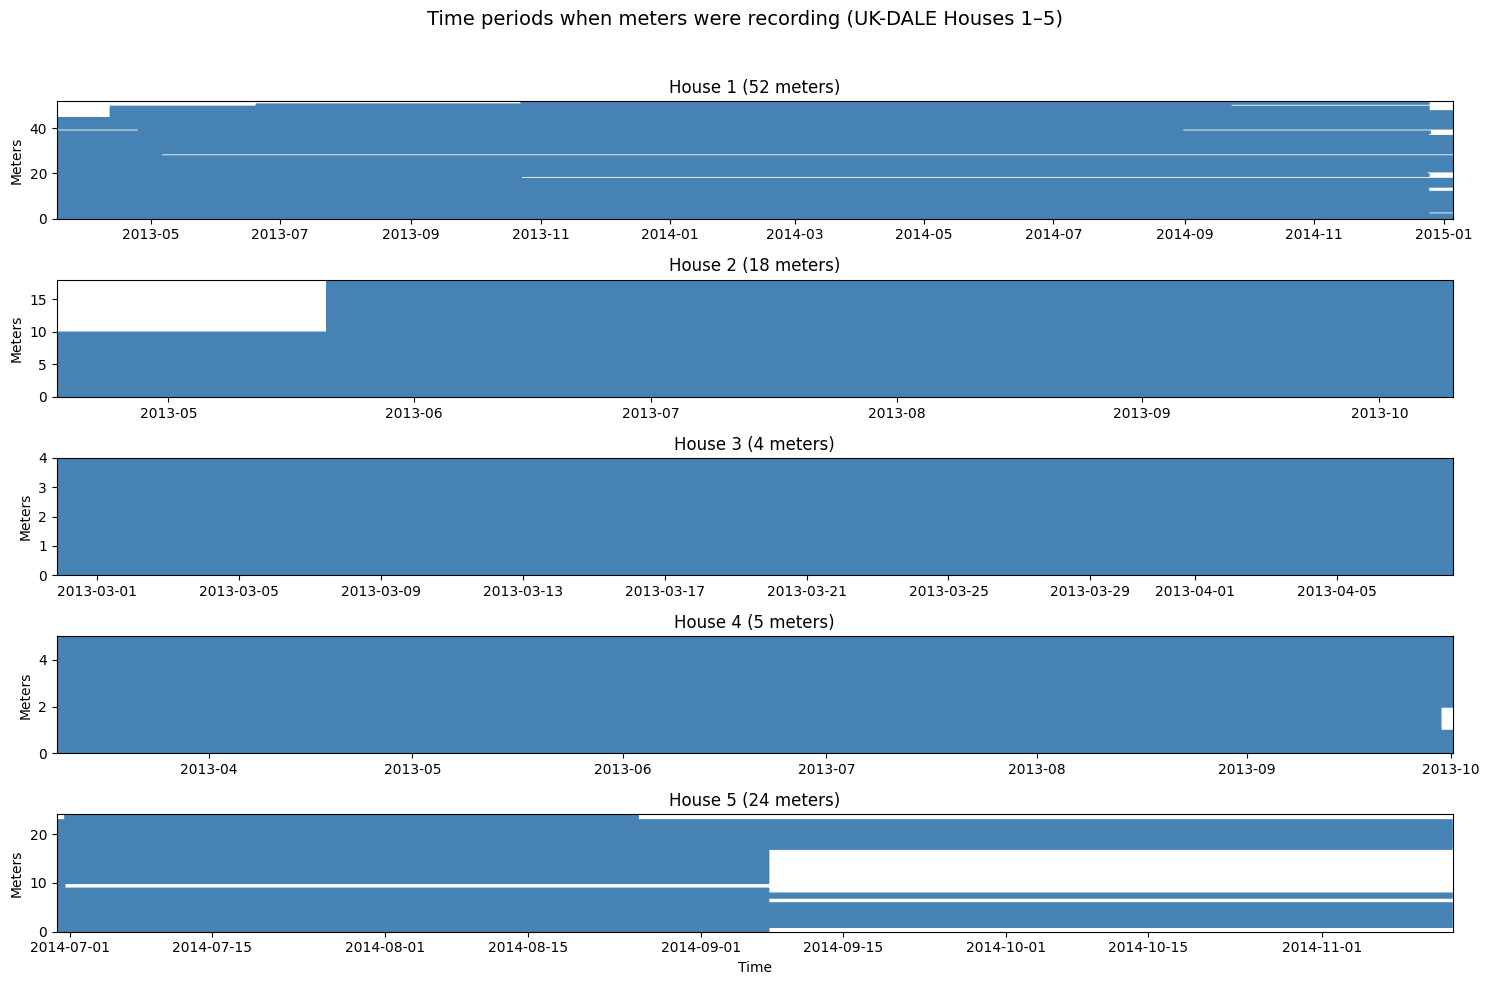

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Create subplots for the 5 houses
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=False)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    # Get mains for available time index
    mains = elec.mains()
    df = next(mains.load(sample_period=60))  # 1-min sampling
    df = df.dropna()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        continue
    
    # Extract this house's time range
    start, end = df.index.min(), df.index.max()
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        df_meter = next(meter.load(sample_period=60))
        df_meter = df_meter.dropna()
        if df_meter.empty:
            continue
        axes[i-1].fill_between(
            df_meter.index, j, j+1,
            color="steelblue"
        )
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(start, end)
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

plt.xlabel("Time")
plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:

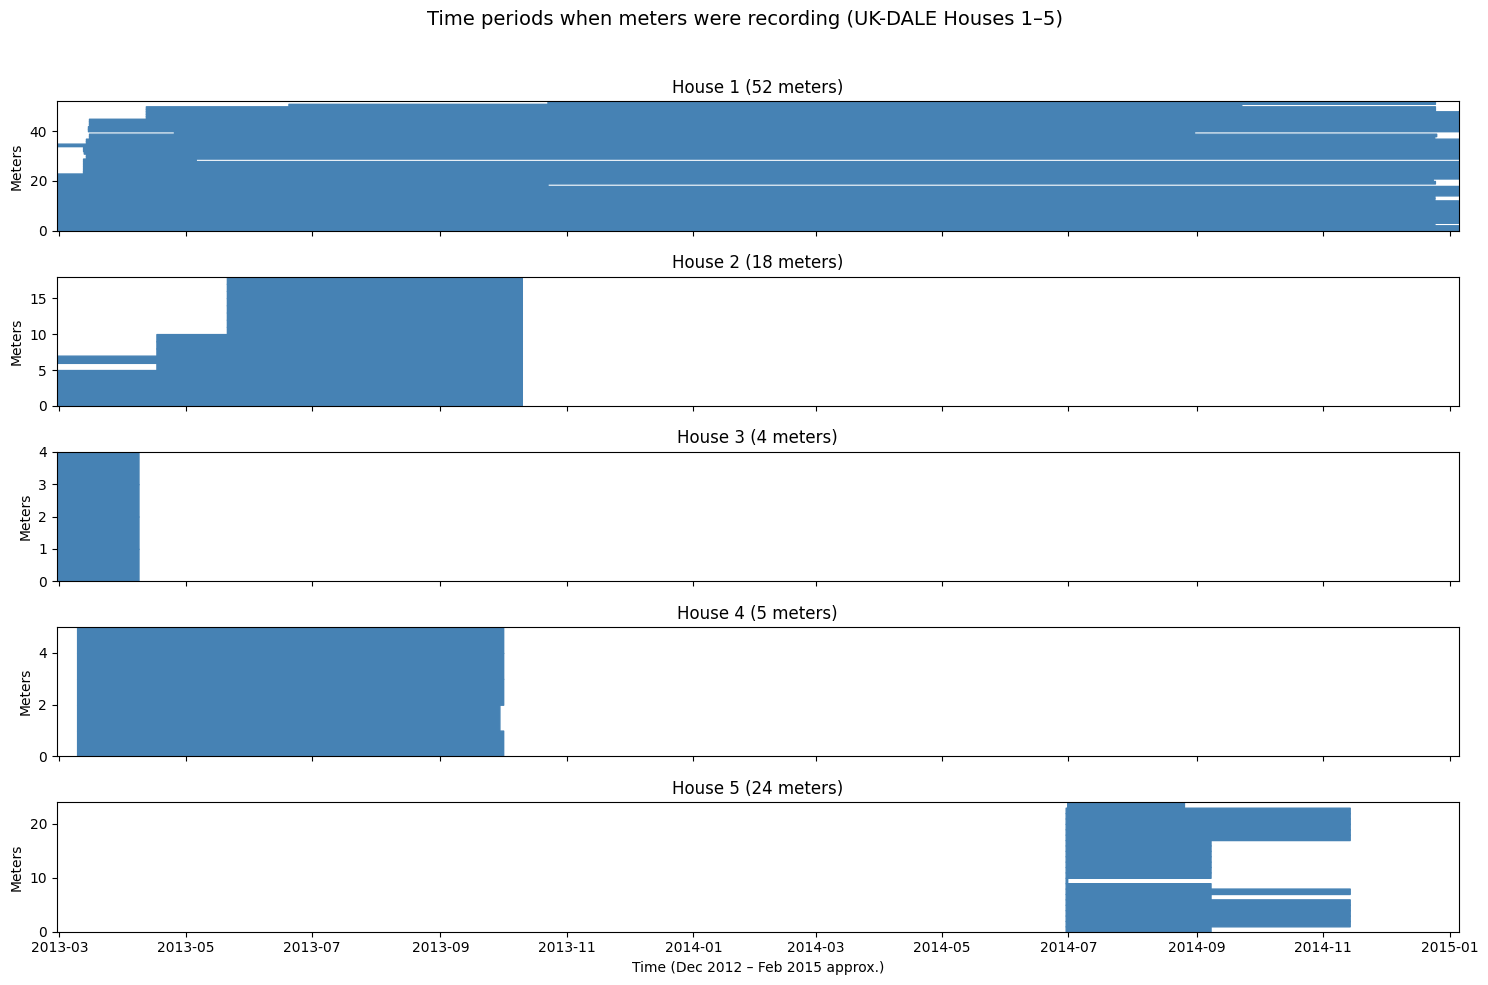

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# --- Find global start and end across all buildings ---
global_starts = []
global_ends = []

for i in range(1, 6):
    building = dataset.buildings[i]
    mains = building.elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
        if not df.empty:
            global_starts.append(df.index.min())
            global_ends.append(df.index.max())
    except:
        continue

global_start = min(global_starts)
global_end = max(global_ends)

# --- Create subplots ---
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    mains = elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
    except:
        df = pd.DataFrame()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        axes[i-1].set_xlim(global_start, global_end)
        continue
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        try:
            df_meter = next(meter.load(sample_period=60))
            df_meter = df_meter.dropna()
            if df_meter.empty:
                continue
            axes[i-1].fill_between(
                df_meter.index, j, j+1,
                color="steelblue"
            )
        except:
            continue
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(global_start, global_end)   # ✅ force same x-axis for all
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

# X-axis shared for all
plt.xlabel("Time (Dec 2012 – Feb 2015 approx.)")
plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:

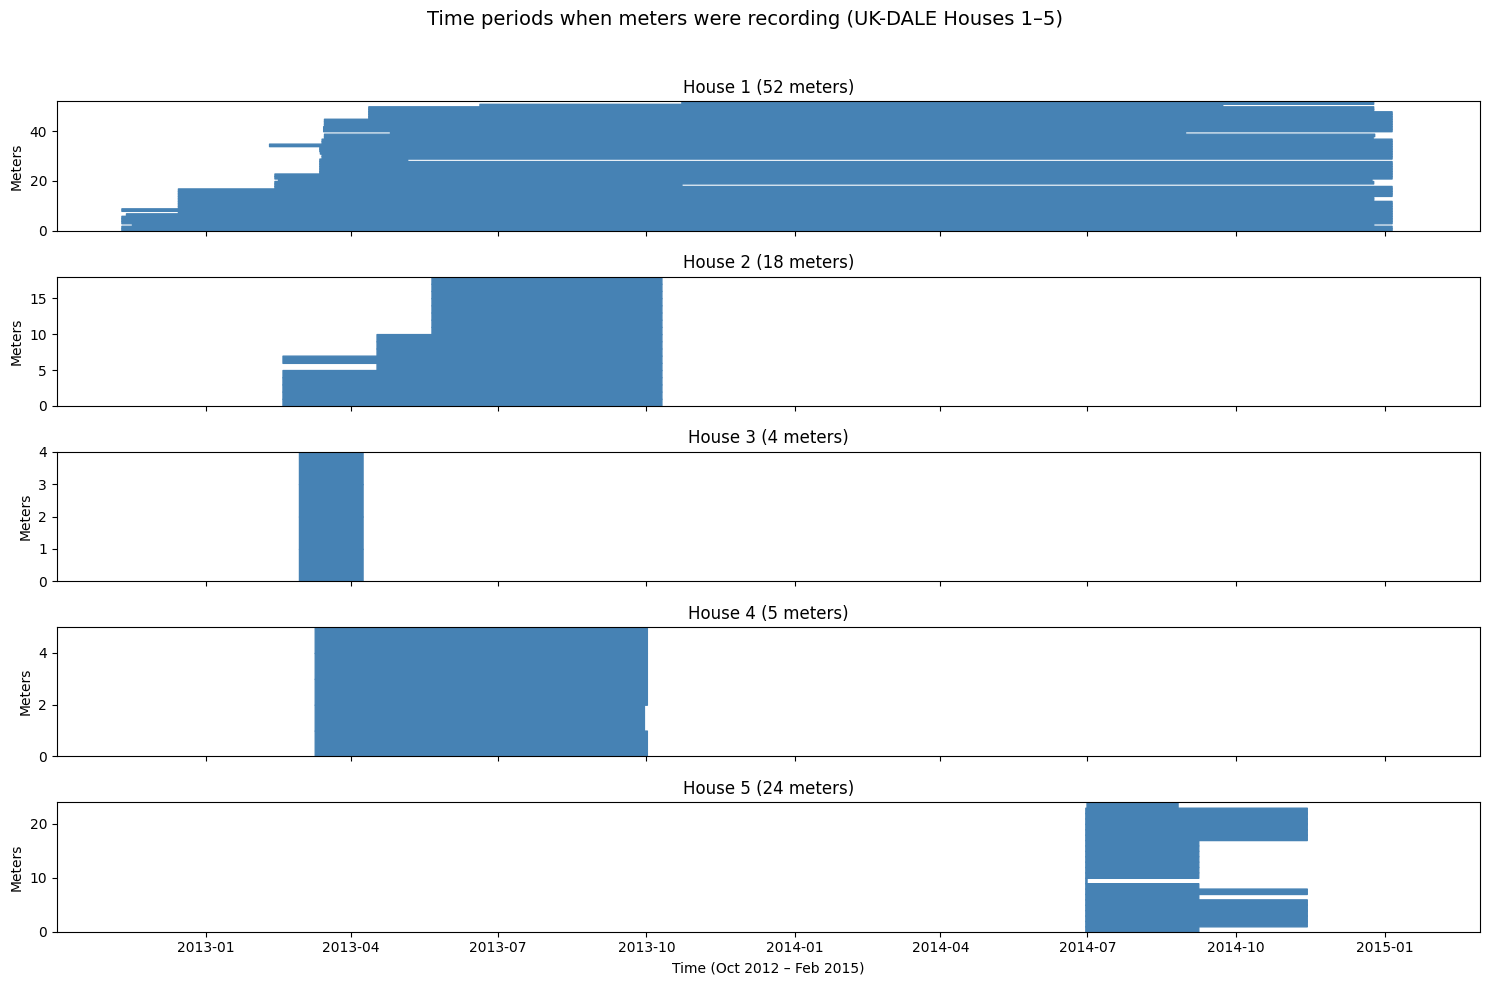

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# --- Define fixed global x-axis range ---
global_start = pd.Timestamp("2012-10-01", tz="UTC")  # start October 2012
global_end = pd.Timestamp("2015-02-28 23:59:59", tz="UTC")  # end Feb 2015

# --- Create subplots ---
fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

for i in range(1, 6):
    building = dataset.buildings[i]
    elec = building.elec
    
    mains = elec.mains()
    try:
        df = next(mains.load(sample_period=60))
        df = df.dropna()
    except:
        df = pd.DataFrame()
    
    if df.empty:
        axes[i-1].set_title(f"House {i} (no data)")
        axes[i-1].set_xlim(global_start, global_end)
        axes[i-1].set_ylim(0, 1)
        continue
    
    # For each submeter, mark availability
    for j, meter in enumerate(elec.submeters().meters):
        try:
            df_meter = next(meter.load(sample_period=60))
            df_meter = df_meter.dropna()
            if df_meter.empty:
                continue
            axes[i-1].fill_between(
                df_meter.index, j, j+1,
                color="steelblue"
            )
        except:
            continue
    
    # Style
    axes[i-1].set_title(f"House {i} ({len(elec.submeters().meters)} meters)")
    axes[i-1].set_ylabel("Meters")
    axes[i-1].set_xlim(global_start, global_end)
    axes[i-1].set_ylim(0, len(elec.submeters().meters))

# Only show x-axis ticks on the last subplot
for ax in axes[:-1]:
    ax.label_outer()

axes[-1].set_xlabel("Time (Oct 2012 – Feb 2015)")

plt.suptitle("Time periods when meters were recording (UK-DALE Houses 1–5)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))
c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


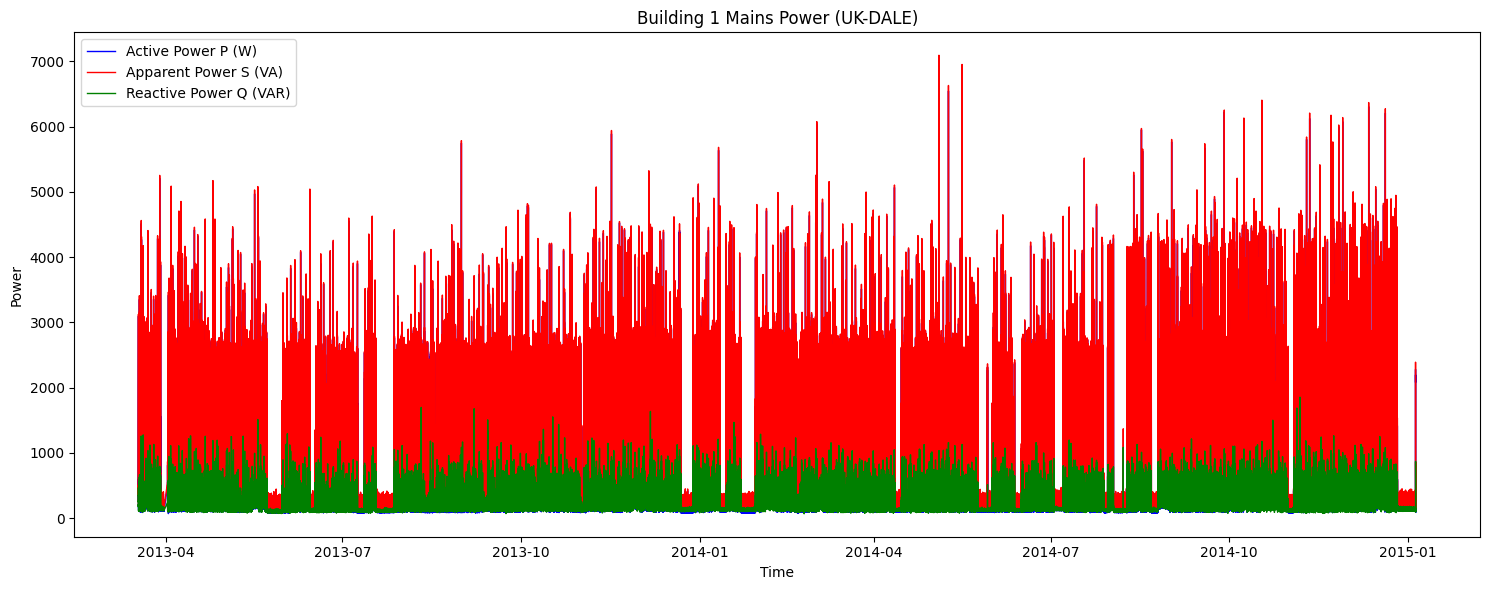

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
import pandas as pd
import numpy as np

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")

# Select building 1 mains
building = dataset.buildings[1]
mains = building.elec.mains()

# Load 1 day of data (for readability, you can expand this to whole range)
df = next(mains.load(sample_period=60))  # 1-min sampling
df = df.dropna()

# Some mains contain multi-index columns, e.g. ('power', 'active') or ('power', 'apparent')
if ('power', 'active') in df.columns:
    P = df[('power', 'active')]
else:
    P = df.iloc[:,0]   # fallback

if ('power', 'apparent') in df.columns:
    S = df[('power', 'apparent')]
else:
    S = None

# Compute Q (reactive power) if S exists
if S is not None:
    Q = np.sqrt(np.clip(S**2 - P**2, 0, None))  # ensure non-negative under sqrt
else:
    Q = None

# Plot results
plt.figure(figsize=(15,6))
plt.plot(P.index, P, label="Active Power P (W)", color="blue", linewidth=1)

if S is not None:
    plt.plot(S.index, S, label="Apparent Power S (VA)", color="red", linewidth=1)
if Q is not None:
    plt.plot(Q.index, Q, label="Reactive Power Q (VAR)", color="green", linewidth=1)

plt.title("Building 1 Mains Power (UK-DALE)")
plt.ylabel("Power")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


Detect Activation for the Appliances


In [ ]:
from nilmtk import DataSet

# Load dataset
dataset = DataSet(r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5")
elec = dataset.buildings[1].elec

# Pick target appliance (e.g., fridge)
fridge = elec['fridge']

activations = fridge.get_activations()
print(len(activations))


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


18872


In [ ]:
# Extract individual operating cycles ("activations") from the appliance's power signal
activations = fridge.get_activations(
    on_power_threshold=50,  # The power threshold (in Watts) that defines when the appliance is considered "ON".
                            # Any power reading above this value is part of an activation. Readings below are "OFF".
                            # This ignores the fridge's small standby power and only captures significant compressor cycles.

    min_off_duration=60,    # The minimum duration (in seconds) the appliance must be below the threshold
                            # to be considered truly "OFF". This prevents brief power dips during a single
                            # cooling cycle from being incorrectly split into multiple smaller activations.

    min_on_duration=60      # The minimum duration (in seconds) a power reading must be above the threshold
                            # to be considered a valid activation. This filters out transient noise and
                            # very short, insignificant power spikes that are not part of a complete cooling cycle.
)

print(f"Number of significant fridge activations found: {len(activations)}")

c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


Number of significant fridge activations found: 18872


Try TVDR-TDWS Feature Extraction
Step 1: Find Activation Event

Step 1: Finding activation events...
Loading dataset...
Loading power data...
Detecting activation events...

Found 5 activation events:
Event 1: 2013-11-08 07:18:24+00:00
Event 2: 2013-11-08 08:05:12+00:00
Event 3: 2013-11-08 09:34:54+00:00
Event 4: 2013-11-08 09:36:30+00:00
Event 5: 2013-11-08 18:39:24+00:00


c:\Users\Raymond Tie\Desktop\NILM\.venv\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))



Plot saved as 'activation_events.png'

Step 1 completed! These T₁ values are ready for Step 2.


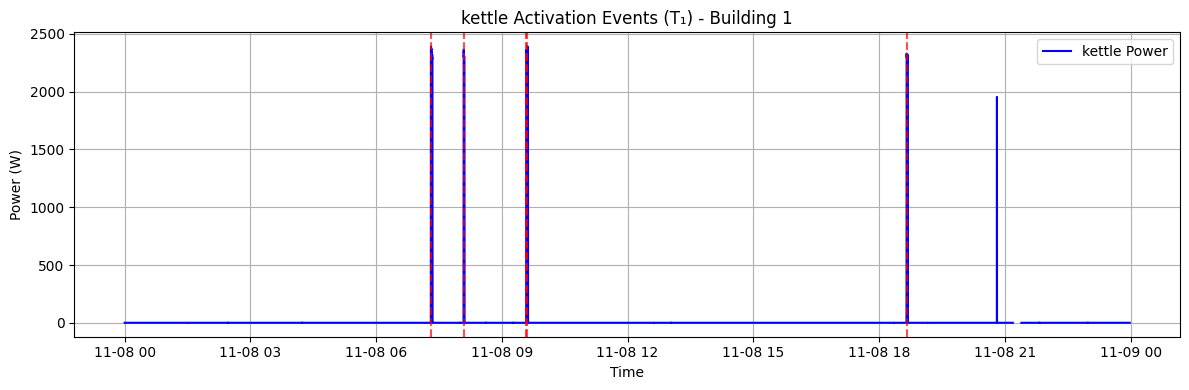

In [17]:
#!/usr/bin/env python3
"""
Simple Step 1: Find Appliance Activation Events using NILMTK
"""

import pandas as pd
import matplotlib.pyplot as plt
from nilmtk import DataSet
from nilmtk.utils import get_datastore

# Configuration
dataset_path = r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5"
building = 1
appliance = "kettle"
threshold_power = 2000  # Watts
start_time = "2013-11-08 00:00:00"
end_time = "2013-11-08 23:59:00"

print("Step 1: Finding activation events...")
print("=" * 50)

try:
    # Load the dataset
    print("Loading dataset...")
    dataset = DataSet(dataset_path)
    dataset.set_window(start=start_time, end=end_time)

    # Get the electrical data for the building
    elec = dataset.buildings[building].elec

    # Get the specific appliance (kettle)
    kettle_meter = elec[appliance]

    # Load the power data - FIXED: Using proper power_series method
    print("Loading power data...")
    power_series = next(kettle_meter.power_series(sample_period=6))  # 6 seconds sample period
    power_data = pd.Series(power_series, index=power_series.index)

    if power_data.empty:
        print("No power data found!")
        dataset.store.close()
        exit()

    # Find activation events
    print("Detecting activation events...")
    activations = []
    prev_power = 0
    activation_times = []

    for timestamp, power in power_data.items():
        if power > threshold_power and prev_power <= threshold_power:
            # This is an activation event
            activation_times.append(timestamp)
        prev_power = power

    print(f"\nFound {len(activation_times)} activation events:")
    for i, time in enumerate(activation_times, 1):
        print(f"Event {i}: {time}")

    # Create a simple plot
    plt.figure(figsize=(12, 4))
    plt.plot(power_data.index, power_data.values, 'b-', label=f'{appliance} Power')

    # Mark each activation event
    for time in activation_times:
        plt.axvline(x=time, color='red', linestyle='--', alpha=0.7)

    plt.title(f'{appliance} Activation Events (T₁) - Building {building}')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig('activation_events.png', dpi=150, bbox_inches='tight')
    print("\nPlot saved as 'activation_events.png'")

    print("\nStep 1 completed! These T₁ values are ready for Step 2.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()

finally:
    # Ensure the dataset is always closed
    if 'dataset' in locals():
        dataset.store.close()